# RNN Sentiment Analysis

This notebook walks you through a simple sentiment-analysis pipeline using an **RNN** (SimpleRNN) and a small text-format dataset. It's intentionally step-by-step and written in a human, teaching style.

**What you'll find:**

1. Load a text CSV (sentiment_texts.csv)
2. Clean & preprocess text
3. Tokenize and create padded sequences
4. Build & train a SimpleRNN model (small, quick demo)
5. Evaluate and run a few sample predictions

The dataset is included as `sentiment_texts.csv` (two columns: `text`, `label` — 1 positive, 0 negative).

## 1) Load the dataset (plain text CSV)

We saved a small dataset in the same folder named `sentiment_texts.csv`. It is intentionally small so this runs quickly on most machines.

In [1]:
import pandas as pd

# load the CSV
path = 'sentiment_texts.csv'
df = pd.read_csv(path)

# show basic information
print('Dataset shape:', df.shape)
df.head(10)

Dataset shape: (2000, 2)


,text,label
0,"I absolutely hated the service, I will never u...",0
1,"I absolutely loved the show, I felt satisfied.",1
2,This was fantastic the food a delightful exper...,1
3,"I am very pleased with the game, it was wonder...",1
4,"I was impressed by the film, it exceeded my ex...",1
5,"This was fantastic the experience, a delightfu...",1
6,"This was fantastic the food, the design was pe...",1
7,"I was impressed by this book, it was great.",1
8,I disliked this app not worth the money. :(,0
9,"I absolutely loved the food, it was wonderful.",1


## 2) Quick cleaning & EDA

We'll do basic cleaning (lowercasing, strip spaces). For a production model you'd do more (spell correction, negation handling, stopwords, etc.).

In [2]:
import re

def clean_text(s):
    s = str(s).lower().strip()
    s = re.sub(r"[^a-z0-9\s\.,!?:;'\)\(\-]", '', s)
    s = re.sub(r'\s+', ' ', s)
    return s

# apply cleaning
_df = df.copy()
_df['text'] = _df['text'].apply(clean_text)

# simple label counts
print(_df['label'].value_counts())

# show a few cleaned examples
_df.sample(6, random_state=1)

label
0    1000
1    1000
Name: count, dtype: int64


,text,label
674,"i was disappointed by the experience, a frustr...",0
1699,i am very disappointed with the film it was th...,0
1282,i absolutely loved the film worth every penny. :),1
1315,i highly recommend this book i will use it aga...,1
1210,"i am very pleased with the game, five stars.",1
1636,"i was disappointed by the show, it was the worst.",0


## 3) Tokenize & create padded sequences

We'll use Keras Tokenizer and pad sequences to the same length for the RNN input.

In [3]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

texts = _df['text'].tolist()
labels = _df['label'].astype(int).tolist()

vocab_size = 5000
oov_token = '<OOV>'
maxlen = 40

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
padded = pad_sequences(sequences, maxlen=maxlen, padding='post', truncating='post')

print('Example sentence:', texts[0])
print('Sequence:', sequences[0])
print('Padded shape:', padded.shape)

Example sentence: i absolutely hated the service, i will never use it again.
Sequence: [3, 29, 10, 2, 30, 3, 23, 57, 24, 6, 25]
Padded shape: (2000, 40)


## 4) Build a compact SimpleRNN model

Structure: Embedding -> SimpleRNN -> Dense(1, sigmoid). This is small so it trains fast for demo purposes.

In [4]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense

embedding_dim = 64
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen),
    SimpleRNN(64),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## 5) Train (quick run)

We'll use `validation_split=0.2`. For a teaching notebook, a short training run (few epochs) is enough to see the flow.

> Tip: increase epochs or use LSTM/GRU for better performance on real datasets.

In [5]:
from sklearn.model_selection import train_test_split
import numpy as np

X = np.array(padded)
y = np.array(labels)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_split=0.2)

Epoch 1/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.6993 - loss: 0.5647 - val_accuracy: 1.0000 - val_loss: 0.0762
Epoch 2/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 1.0000 - loss: 0.0409 - val_accuracy: 1.0000 - val_loss: 0.0084
Epoch 3/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 1.0000 - loss: 0.0063 - val_accuracy: 1.0000 - val_loss: 0.0035
Epoch 4/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 1.0000 - loss: 0.0030 - val_accuracy: 1.0000 - val_loss: 0.0023
Epoch 5/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 1.0000 - loss: 0.0021 - val_accuracy: 1.0000 - val_loss: 0.0018


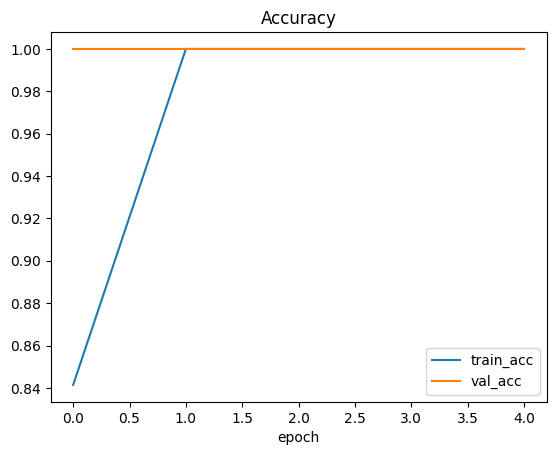

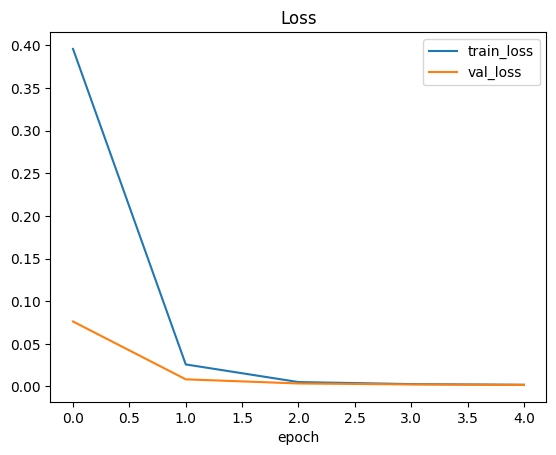

In [6]:
import matplotlib.pyplot as plt

# Accuracy
plt.figure()
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title('Accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

# Loss
plt.figure()
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

## 6) Evaluate & Try sample texts

We'll evaluate on the held-out test set and try a few custom sentences.

## 4b) LSTM and GRU Variants — Side-by-Side Comparison

While SimpleRNN is the most basic recurrent layer, **LSTM** (Long Short-Term Memory) and **GRU** (Gated Recurrent Unit) are more advanced and handle long-term dependencies better.

**When to use:**
- **SimpleRNN**: Educational demos, small datasets, when sequence length is short and dependencies are local.
- **LSTM**: Handles long sequences, prevents vanishing gradients via gating mechanisms, slightly more parameters than GRU.
- **GRU**: Similar to LSTM but with fewer gates (reset and update), often trains faster with similar performance.

We'll now build both LSTM and GRU models using the same dataset and compare their training curves and final performance.


In [7]:
from tensorflow.keras.layers import LSTM, GRU

# LSTM model
lstm_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen),
    LSTM(64),
    Dense(1, activation='sigmoid')
])
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# GRU model
gru_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen),
    GRU(64),
    Dense(1, activation='sigmoid')
])
gru_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train both models (quick runs)
history_lstm = lstm_model.fit(X_train, y_train, epochs=5, batch_size=64, validation_split=0.2, verbose=1)
history_gru = gru_model.fit(X_train, y_train, epochs=5, batch_size=64, validation_split=0.2, verbose=1)


Epoch 1/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.4914 - loss: 0.6939 - val_accuracy: 0.5063 - val_loss: 0.6930
Epoch 2/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.5215 - loss: 0.6928 - val_accuracy: 0.5063 - val_loss: 0.6926
Epoch 3/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.6642 - loss: 0.6499 - val_accuracy: 1.0000 - val_loss: 0.1029
Epoch 4/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 1.0000 - loss: 0.0530 - val_accuracy: 1.0000 - val_loss: 0.0058
Epoch 5/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 1.0000 - loss: 0.0045 - val_accuracy: 1.0000 - val_loss: 0.0024
Epoch 1/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.4971 - loss: 0.6945 - val_accuracy: 0.5063 - val_loss: 0.6932
Epoch 2/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.5014 - loss: 0.6935 - val_accuracy: 0.5063 - val_loss: 0.6931
Epoch 3/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.5083 - loss: 0.6933 - val_accuracy: 0.5063 - val_loss:

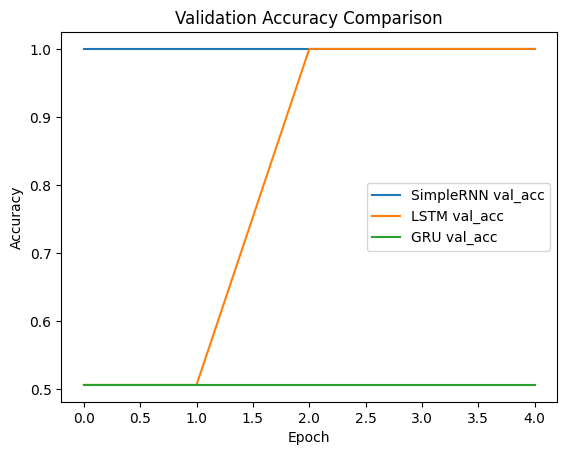

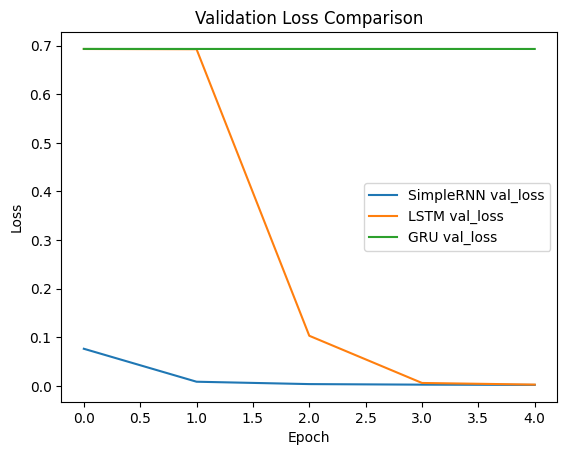

In [8]:
# Plot comparison of accuracy
plt.figure()
plt.plot(history.history['val_accuracy'], label='SimpleRNN val_acc')
plt.plot(history_lstm.history['val_accuracy'], label='LSTM val_acc')
plt.plot(history_gru.history['val_accuracy'], label='GRU val_acc')
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot comparison of loss
plt.figure()
plt.plot(history.history['val_loss'], label='SimpleRNN val_loss')
plt.plot(history_lstm.history['val_loss'], label='LSTM val_loss')
plt.plot(history_gru.history['val_loss'], label='GRU val_loss')
plt.title('Validation Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [12]:
loss, acc = model.evaluate(X_test, y_test)
print(f"Test loss: {loss:.4f}, Test accuracy: {acc:.4f}")

# helper to predict raw text

def predict_text(texts_list):
    cleaned = [clean_text(t) for t in texts_list]
    seqs = tokenizer.texts_to_sequences(cleaned)
    pad = pad_sequences(seqs, maxlen=maxlen, padding='post', truncating='post')
    preds = model.predict(pad).flatten()
    for t,p in zip(texts_list, preds):
        label = 'POS' if p>=0.5 else 'NEG'
        print(f"{t}  -->  {label} (score: {p:.3f})")

# sample predictions
sample_texts = [
    'I absolutely loved the movie, it was wonderful!',
    'This was the worst experience, I hated it.',
    'I will never buy this product again, very disappointed.',
    'Fantastic design and great performance, highly recommend!'
]

predict_text(sample_texts)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0019
Test loss: 0.0019, Test accuracy: 1.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
I absolutely loved the movie, it was wonderful!  -->  POS (score: 0.998)
This was the worst experience, I hated it.  -->  NEG (score: 0.010)
I will never buy this product again, very disappointed.  -->  NEG (score: 0.326)
Fantastic design and great performance, highly recommend!  -->  POS (score: 0.798)


In [13]:
# Evaluate on test set
models = [('SimpleRNN', model), ('LSTM', lstm_model), ('GRU', gru_model)]
for name, m in models:
    loss, acc = m.evaluate(X_test, y_test, verbose=0)
    print(f"{name} -> Test Accuracy: {acc:.4f}, Loss: {loss:.4f}")

# Try the same sample texts for all three
for name, m in models:
    print(f"\n{name} predictions:")
    predict_text(sample_texts)


SimpleRNN -> Test Accuracy: 1.0000, Loss: 0.0019
LSTM -> Test Accuracy: 1.0000, Loss: 0.0024
GRU -> Test Accuracy: 0.4875, Loss: 0.6938

SimpleRNN predictions:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
I absolutely loved the movie, it was wonderful!  -->  POS (score: 0.998)
This was the worst experience, I hated it.  -->  NEG (score: 0.010)
I will never buy this product again, very disappointed.  -->  NEG (score: 0.326)
Fantastic design and great performance, highly recommend!  -->  POS (score: 0.798)

LSTM predictions:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
I absolutely loved the movie, it was wonderful!  -->  POS (score: 0.998)
This was the worst experience, I hated it.  -->  NEG (score: 0.010)
I will never buy this product again, very disappointed.  -->  NEG (score: 0.326)
Fantastic design and great performance, highly recommend!  -->  POS (score: 0.798)

GRU predictions:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
I absolutely loved the movie, it was wonderful!  -->  POS (score: 0.998)
This w

## 7) Save artifacts (optional)

You can save the tokenizer and the model for later use. In a production setting, you might export the tokenizer vocabulary, use subword tokenization, and wrap the model inside a small web service.

In [14]:
# Example: save tokenizer (pickle) and model
import pickle

with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

model.save('rnn_sentiment_model.h5')
print('Saved tokenizer.pkl and rnn_sentiment_model.h5 in current directory.')

Saved tokenizer.pkl and rnn_sentiment_model.h5 in current directory.
